In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

# Definitions for this notebook:

In [3]:
z_directory = {"33":"z=2","40":"z=1.5","50":"z=1"}

In [4]:
orbit_dict = {}
for snap in [33,40,50]:
    f = h5py.File(f"{paths.path_data}orbitdata_{snap}.hdf5",'r')
    orbit_dict[str(snap)] = {}
    for key, val in f.items():
        orbit_dict[str(snap)][key] = np.array(val)
    f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

# Defining the beginning of the orbit

## How do observability timescales change w different orbit starting times

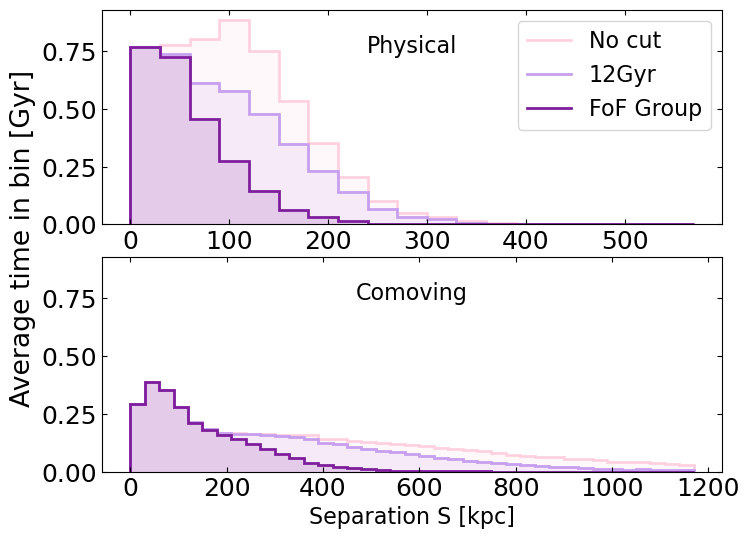

In [5]:
'''
# trying slight modification of the elapsed_time array construction compared to previous plots
# this approximates that a pair stayed at the same separation for the amount of 
# time elapsed since the snapshot before
---
might need to do something else if we are only considering seps > 10kpc? 
'''

fig, ax = plt.subplots(2, 1, figsize=(8,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

    # get physical separations from snapshot 40
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]

colors = ["xkcd:light pink","xkcd:lavender","xkcd:purple"]
j = 0    

for i in ["No cut","12Gyr","FoF Group"]:


        # get comoving separations
    scales = snap_dict['Scale'][::-1][:-1] # gives scale in same order as orbit data
    scale_matrix = np.tile(scales,(len(sep_matrix_kpc),1))
    sep_matrix_ckpc = sep_matrix_kpc/scale_matrix

        # get elapsed time (positive)
    elapsed_time = np.diff(snap_dict["Lookback Time"][::-1]) 
    elapsed_matrix = np.tile(elapsed_time,(len(sep_matrix_kpc),1))

        # create mask to filter out nan and zero values from the separation matrix
    nan_sep = np.isnan(sep_matrix_kpc)
    zero_sep = sep_matrix_kpc == 0
    matrix_mask = ~nan_sep&~zero_sep

        # create mask to only select mergers
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

        # define bins for histograms
    bins_kpc = np.arange(0,600,30)
    bins_ckpc = np.arange(0,1200,30)
    
        # orbit start at LBT of 12Gyr
    start_12gyrmask = (snap_dict["Lookback Time"][::-1][:-1] < 12)    
    start_12gyr = np.tile(start_12gyrmask,(len(sep_matrix_kpc),1))
    
        # orbit start when in same FoF group
    start_FoF = orb['GroupFlag'] == True
    
        # create full matrix mask including:
        # mergers, non-zero separations, and start time
    if i == "12Gyr":
        start_mask = start_12gyr&matrix_mask&merge_mask
        
    elif i =="FoF Group":
        start_mask = start_FoF&matrix_mask&merge_mask
    else:
        start_mask = matrix_mask&merge_mask
        
        #defining 
    xx_kpc = sep_matrix_kpc[start_mask]
    xx_ckpc = sep_matrix_ckpc[start_mask]
    
        # calculate number of mergers and elapsed time - used for weights 
    elapsed = elapsed_matrix[start_mask]
    num_mergers = np.count_nonzero(merger_array)

        # create histograms
    vals_kpc, edges_kpc = np.histogram(xx_kpc,bins=bins_kpc,weights=elapsed/num_mergers)
    vals_ckpc, edges_ckpc = np.histogram(xx_ckpc,bins=bins_ckpc,weights=elapsed/num_mergers)

    ###                      ###
    # physical separation plot #
    ###                      ###
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[0].stairs(vals_kpc,edges_kpc,color=colors[j],lw=2,label=i)

    ###                      ###
    # comoving separation plot #
    ###                      ###
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,fill=True,alpha=0.15)
    ax[1].stairs(vals_ckpc,edges_ckpc,color=colors[j],lw=2,label=i)

    j += 1

for i,label in enumerate(["Physical","Comoving"]):
    x0,x1 = ax[i].get_xlim()
    y0,y1 = ax[i].get_ylim()
    locx = 0.5*(x1-x0) + x0
    locy = 0.80*(y1-y0) + y0
    ax[i].text(locx,locy,label,ha="center")
    
ax[0].legend()
ax[1].set_xlabel("Separation S [kpc]")
fig.supylabel("Average time in bin [Gyr]",x=0.01)
plt.show()


### Distribution of starting times based on "same FoF group" definition

In [6]:
for i in range(len(orb['GroupFlag'])):
    if orb['MergerFlag'][i] == 0:
        continue
    print("Index:",i, "Index where the group flag changes:",np.where(np.diff(orb['GroupFlag'][i]))[0])

Index: 0 Index where the group flag changes: [61]
Index: 2 Index where the group flag changes: [60]
Index: 3 Index where the group flag changes: [14 15 59]
Index: 4 Index where the group flag changes: [63]
Index: 5 Index where the group flag changes: [59]
Index: 6 Index where the group flag changes: [64]
Index: 7 Index where the group flag changes: [67]
Index: 8 Index where the group flag changes: [63]
Index: 9 Index where the group flag changes: [56 57 64]
Index: 11 Index where the group flag changes: [48 49 62]
Index: 12 Index where the group flag changes: [59]
Index: 13 Index where the group flag changes: [72]
Index: 15 Index where the group flag changes: [62]
Index: 18 Index where the group flag changes: [61]
Index: 19 Index where the group flag changes: [61]
Index: 20 Index where the group flag changes: [61]
Index: 22 Index where the group flag changes: [63]
Index: 24 Index where the group flag changes: [60]
Index: 25 Index where the group flag changes: [44 45 62]
Index: 26 Index 

One complication of using the Group Definition: do I begin when the pair is FIRST in the same halo? There are quite a lot of pairs that move in and out of a group over time. 

Case 1: 
    Use the earliest time that the halos are in the same group.
    
Case 2:
    Use the lookback time associated with most recent entrance into halo.
    
Proceeding with Case 1 because there are examples of halos moving in and out of groups for only like... 2 out of MANY snapshot where they are in the same group. 
For example, halo @ index 3.

In [7]:
# case 2

group_entry_time = np.zeros(np.count_nonzero(orb["MergerFlag"]))
it_girl = 0
for i in range(len(orb['GroupFlag'])):
    if orb['MergerFlag'][i]:
        index = np.where(np.diff(orb['GroupFlag'][i]))[0][-1]
        group_entry_time[it_girl] = snap_dict["Lookback Time"][::-1][index]
        
        it_girl += 1
        


In [8]:
min(group_entry_time)

9.509810862541364

This makes sense because there should be no FIRST group entry flags AFTER z=1.5 since, by definition, the pairs are picked AT z=1.5 to be in the same group, so that's the latest they could be in the same group.

In [9]:
vals, edges = np.histogram(group_entry_time,bins=snap_dict["Lookback Time"][:50:2][::-1])

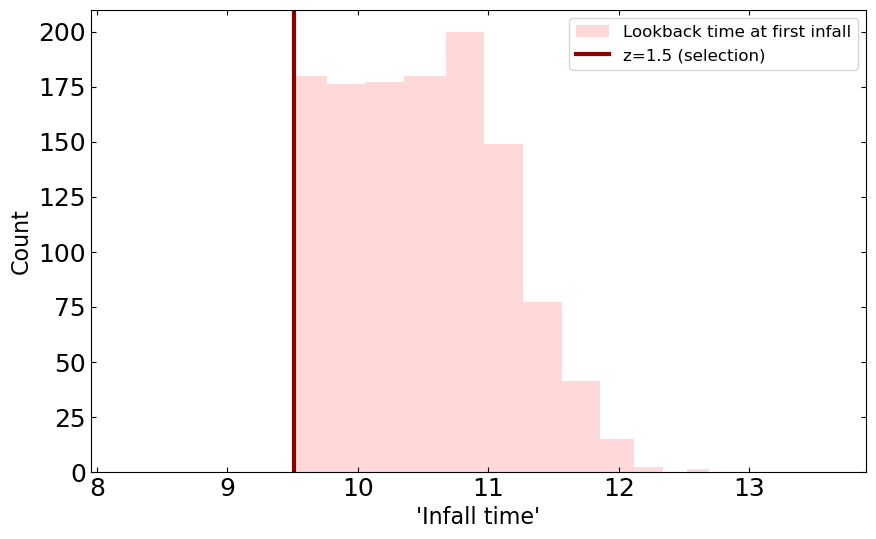

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

ax.stairs(vals,edges,color="red",lw=2,fill=True,alpha=0.15,label="Lookback time at first infall")
ax.axvline(snap_dict["Lookback Time"][40],label="z=1.5 (selection)",color='darkred',lw=3)
plt.legend(fontsize=12)
plt.xlabel("'Infall time'")
plt.ylabel("Count")
plt.savefig(f"{paths.path_plots}5_define_beginning/countvsinfalltime.pdf")
plt.show()

In [11]:
np.where(~np.isnan(sep_matrix_kpc[0]))[0][-1]

95

In [12]:
# if I take the lookback time where a separation is first defined, how does that compare? 

first_separation_time = np.zeros(np.count_nonzero(orb["MergerFlag"]))
hype_boy = 0
for i in range(len(orb['GroupFlag'])):
    if orb["MergerFlag"][i]:
#         reversed_seps = sep_matrix_kpc[i][::-1]
        index = np.where(~np.isnan(sep_matrix_kpc[i]))[0][-1]
            # return last non nan element of separation
        first_separation_time[hype_boy] = snap_dict["Lookback Time"][::-1][index]
        hype_boy += 1
                


In [215]:
first_separation_time

array([13.32804767, 13.43254561, 13.38502393, ...,  9.50981086,
        9.50981086, 13.38502393])

In [218]:
snap_dict["Lookback Time"][:50:2][::-1]

array([ 8.22607695,  8.51406791,  8.82244839,  9.14629731,  9.50981086,
        9.76523678, 10.0583425 , 10.35536972, 10.67378679, 10.96405813,
       11.264119  , 11.56499155, 11.8585489 , 12.11422116, 12.33668348,
       12.52106733, 12.69033655, 12.8373698 , 12.95908235, 13.07071103,
       13.1630779 , 13.25559269, 13.32804767, 13.43254561, 13.6234043 ])

In [216]:
vals_first, edges_first = np.histogram(first_separation_time,bins=snap_dict["Lookback Time"][:50:2][::-1])

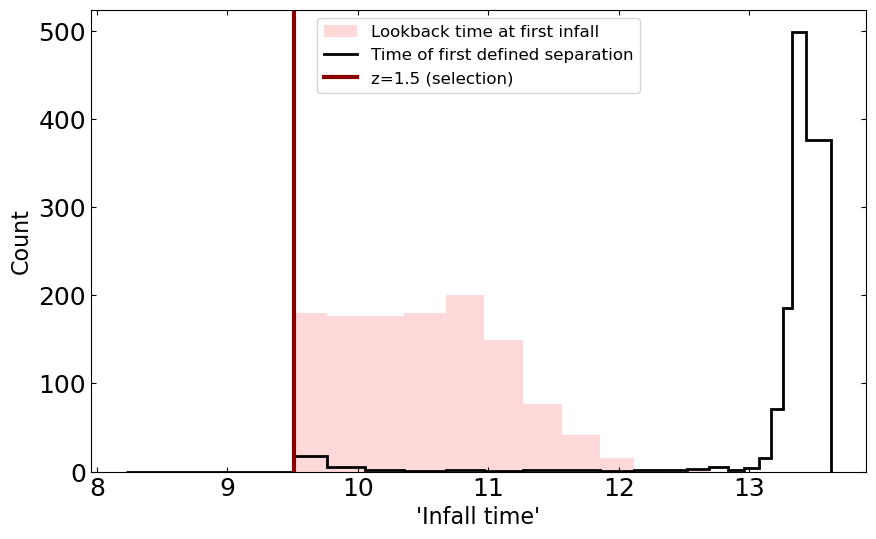

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

ax.stairs(vals,edges,color="red",lw=2,fill=True,alpha=0.15,label="Lookback time at first infall")
ax.stairs(vals_first,edges_first,color="black",lw=2,fill=False,label="Time of first defined separation")
ax.axvline(snap_dict["Lookback Time"][40],label="z=1.5 (selection)",color='darkred',lw=3)
plt.legend(fontsize=12)
plt.xlabel("'Infall time'")
plt.ylabel("Count")
# plt.text(20,175,f"Total mergers:{len(least_seps_nonan)}")
plt.show()

## Distribution of final separation before merger

In [11]:
snap = 40
orb = orbit_dict[str(snap)]
sep_matrix_kpc = orb["Separations"]

Take a look at the separation array for pair # 3

In [189]:
sep_matrix_kpc[3]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,          nan,
        39.61100037,  51.06263623,  21.30316702,  58.91280876,
        86.8633406 , 109.28150076, 107.05155372,  85.23021325,
        30.81911558,  38.77572213, 108.28030735, 158.80754026,
       198.23895365, 229.4899311 , 255.09550151, 274.67619073,
       290.4561235 , 301.75100704, 310.44297364, 318.47898846,
       322.85043507, 323.84673126, 322.91569198, 317.74627131,
       311.20758112, 300.11017108, 292.54894289, 279.79804513,
       265.35458044, 247.51679674, 218.97142642, 211.43128102,
       203.73386373, 180.34786269, 160.02467299, 144.58927253,
       149.21523716, 173.43334235, 188.63911389, 159.16436448,
       136.80428261, 125.84206632, 131.27019483, 154.22646657,
       167.46568245, 197.65009703, 226.40676811, 259.64

Need to trim 0s at beginning of array (they are the 'separation' after merger), and take the first non-nan value of the separation just before that!

In [64]:
least_seps = np.zeros(np.count_nonzero(orb["MergerFlag"]))
jj = 0
for i in range(len(sep_matrix_kpc)):
    if orb["MergerFlag"][i]:
        least_seps[jj] = np.trim_zeros(sep_matrix_kpc[i])[0]
        jj += 1
        # note that least_seps contains nans in the case where a halo separation could not be calculated before merger
        # TODO: should I make it the next separation? or leave it nan? 
        

In [96]:
least_seps_nonan = np.zeros(np.count_nonzero(orb["MergerFlag"]))
jj = 0
for i in range(len(sep_matrix_kpc)):
    if orb["MergerFlag"][i]:
        non_zero = np.trim_zeros(sep_matrix_kpc[i])
        non_nan = non_zero[~np.isnan(non_zero)]
            # return 1st non 0 and non nan element of separation arry 
        least_seps_nonan[jj] = non_nan[0] 
        jj += 1
        

In [97]:
vals, edges = np.histogram(least_seps[~np.isnan(least_seps)],bins=10)
vals_nonan, edges_nonan = np.histogram(least_seps_nonan,bins=np.linspace(0,40,20))

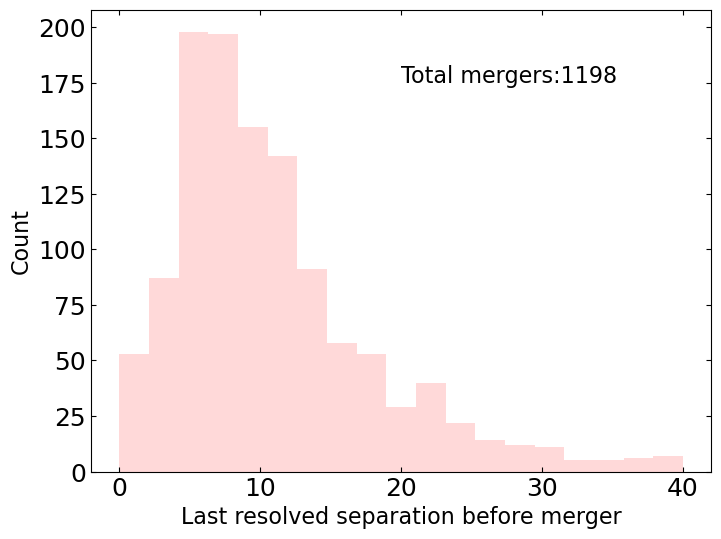

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=False, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1],
                                    'wspace': 0.10,
                                    "hspace":0.15})

ax.stairs(vals_nonan,edges_nonan,color="red",lw=2,fill=True,alpha=0.15)

plt.xlabel("Last resolved separation before merger")
plt.ylabel("Count")
plt.text(20,175,f"Total mergers:{len(least_seps_nonan)}")
plt.show()